In [10]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import functional as F

import numpy as np

import gym
import d4rl

from rlkit.torch.networks import Mlp
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['figure.figsize'] = (15, 10)


In [11]:
def get_bonus(obs, actions, network):
    data = torch.cat((obs, actions), dim=1)
    # print('size of data:{}'.format(data.size()))
    
    with torch.no_grad():
        bonus = network(data)
    print('size of bonus:{}'.format(bonus.size()))
    
    return bonus

In [12]:
def get_bonus_random_actions(obs, actions, network):
    action_shape = actions.shape[0]
    obs_shape = obs.shape[0]
    num_repeat = int (action_shape / obs_shape)
    obs_temp = obs.unsqueeze(1).repeat(1, num_repeat, 1).view(obs.shape[0] * num_repeat, obs.shape[1])
    # feed to the bonus networks
    data = torch.cat((obs_temp, actions), dim=1)
    with torch.no_grad():
        bonus = network(data)
    # reshape
    bonus = bonus.view(obs.shape[0], num_repeat, 1)
    print('size of bonus:{}'.format(bonus.size()))

    return bonus

In [13]:
def get_bonus_noisy_actions(obs, actions, N, sigma, network):
    noise = torch.normal(mean=0, std=sigma, size=(actions.shape[0] * N, actions.shape[-1]))
#     print('noise size:{}'.format(noise.size()))

    obs_temp = obs.unsqueeze(1).repeat(1, N, 1).view(obs.shape[0] * N, obs.shape[1])
    actions_tmp = actions.unsqueeze(1).repeat(1, N, 1).view(actions.shape[0] * N, actions.shape[1])
#     print('obs_temp size:{}'.format(obs_temp.size()))
#     print('actions_tmp size:{}'.format(actions_tmp.size()))

    noisy_actions = actions_tmp + noise
    print('noisy_actions size:{}'.format(noisy_actions.size()))
    bonus = get_bonus(obs_temp, noisy_actions, network_1).view(obs.shape[0], N, 1)
    return bonus

In [14]:
def load_models(model_name):
    
    M = 64
    network = Mlp(
        input_size=obs_dim + action_dim,
        output_size=1,
        hidden_sizes=[M, M],
        output_activation=F.sigmoid,
    )

    
    path = '../models/{}'.format(model_name)
    checkpoint = torch.load(path, map_location='cpu')
    network.load_state_dict(checkpoint['network_state_dict'])

    print('Loading model: {}'.format(path))
    
    return network

In [25]:
def bc_load_models(model_name):
    
    M = 256
    network = Mlp(
        input_size=obs_dim ,
        output_size=action_dim,
        hidden_sizes=[M, M],
    )

    
    path = '../models/{}'.format(model_name)
    checkpoint = torch.load(path, map_location='cpu')
    network.load_state_dict(checkpoint['network_state_dict'])

    print('Loading model: {}'.format(path))
    
    return network

In [16]:
num_random = 10

# walker2d

In [18]:
env_name = 'walker2d-medium-v0'

env = gym.make(env_name)
obs_dim = env.observation_space.low.size
action_dim = env.action_space.low.size

print(obs_dim)
print(action_dim)

dataset = env.get_dataset()
obs = torch.from_numpy(dataset['observations'])
actions = torch.from_numpy(dataset['actions'])
rewards = dataset['rewards']
min_reward = min(rewards)
max_reward = max(rewards)
print('.. using normalization ..')
obs = (obs - obs.mean(axis=0)) / obs.std(axis=0)


print('min_reward:{}, max_reward:{}, range: {}'.format(min_reward, max_reward, max_reward - min_reward))

17
6
.. using normalization ..
min_reward:-5.741327285766602, max_reward:8.771693229675293, range: 14.513020515441895


In [9]:
print(np.mean(dataset['actions']))

0.24028713


In [20]:

model_name = 'Nov-30-2020_1526_walker2d-medium-v0.pt'
network = load_models(model_name)
bonus = get_bonus(obs, actions, network,).detach().cpu().numpy()

Loading model: ../models/Nov-30-2020_1526_walker2d-medium-v0.pt
size of bonus:torch.Size([1000000, 1])


In [34]:
model_name = 'bc_Dec-07-2020_0920_walker2d-medium-v0.pt'
network_bc = bc_load_models(model_name)
actions_bc = network_bc(obs)
                        
print('size of actions_bc:{}'.format(actions_bc.shape))


Loading model: ../models/bc_Dec-07-2020_0920_walker2d-medium-v0.pt
size of actions_bc:torch.Size([1000000, 6])


In [35]:
bonus_bc = get_bonus(obs, actions_bc, network).detach().cpu().numpy()

size of bonus:torch.Size([1000000, 1])


Text(0.5, 0.98, 'walker2d-medium-v0')

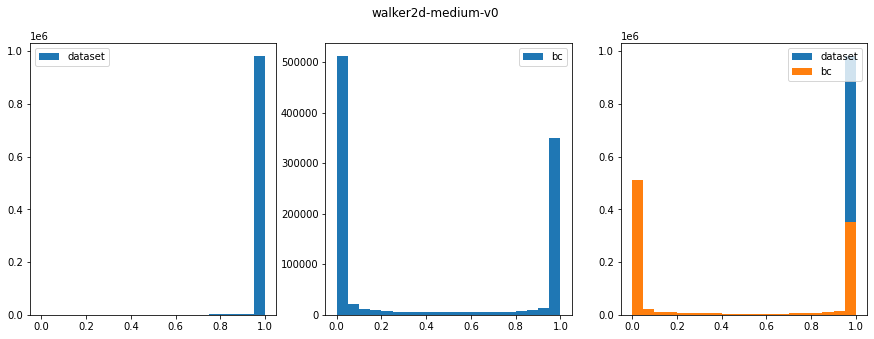

In [37]:
num_bins = 20
matplotlib.rcParams['figure.figsize'] = (15, 5)
fig=plt.figure()
plt.subplot(1, 3, 1)
plt.hist(bonus, bins = num_bins, label='dataset')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(bonus_bc, bins = num_bins, label='bc')
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(bonus, bins = num_bins, label='dataset')
plt.hist(bonus_bc, bins = num_bins, label='bc')
plt.legend(loc='upper right')


plt.suptitle(env_name)

In [38]:
ind = 3
sample_states = obs[:ind]
sample_actions = actions[:ind]

sample_actions_bc = network_bc(sample_states)



In [39]:
sample_actions

tensor([[-0.2126,  0.4730,  0.1843,  0.7734,  0.7279,  0.1576],
        [ 0.4255,  0.8377, -0.0243,  0.9240,  0.4233,  0.1698],
        [-0.0451,  0.6699, -0.1601,  0.9247,  0.5235, -0.0262]])

In [40]:
sample_actions_bc

tensor([[ 0.4783,  0.2856, -0.0357,  0.1822, -0.7259, -0.2568],
        [ 0.4049,  0.3376, -0.1644,  0.1444, -0.7130, -0.2235],
        [ 0.3485,  0.4196, -0.2589,  0.0853, -0.7074, -0.1794]],
       grad_fn=<AddmmBackward>)

In [28]:
random_actions = torch.FloatTensor(actions.shape[0] * num_random, actions.shape[-1]).uniform_(-1, 1)
bonus_random = get_bonus_random_actions(obs, random_actions, network).detach().cpu().numpy()
bonus_random_mean = np.mean(bonus_random, axis=1)


size of bonus:torch.Size([1000000, 10, 1])


In [29]:
ind = np.random.permutation(actions.shape[0])
shuffled_actions = actions[ind]

bonus_shuffled = get_bonus(obs, shuffled_actions, network).detach().cpu().numpy()

size of bonus:torch.Size([1000000, 1])


In [10]:
bonus_random_mean = np.mean(bonus_random, axis=1)
reward_mean = np.mean(rewards)
delta_bonus = abs(bonus_random_mean - bonus).squeeze(1)

delta_bonus_mean = np.mean(delta_bonus)
print('mean reward:{}, delta_bonus:{}'.format(reward_mean,delta_bonus_mean))
rho1_mean = reward_mean / delta_bonus_mean
print('rho1:{0:0.2g}'.format(rho1_mean))


rho2_mean = np.mean(rewards / np.clip(delta_bonus, 1e-9, 1e9))
print('rho2:{0:.2g}'.format(rho2_mean))

mean reward:2.6488335132598877, delta_bonus:0.8878922462463379
rho1:3
rho2:3.8


In [11]:
bonus_random_median = np.mean(bonus_random, axis=1)
reward_median = np.median(rewards)
delta_bonus = abs(bonus_random_median - bonus).squeeze(1)

delta_bonus_median = np.median(delta_bonus)
print('median reward:{}, delta_bonus:{}'.format(reward_median,delta_bonus_median))
rho1_median = reward_median / delta_bonus_median
print('rho1:{0:0.2g}'.format(rho1_median))


rho2_median = np.median(rewards / np.clip(delta_bonus, 1e-9, 1e9))
print('rho2:{0:.2g}'.format(rho2_median))

median reward:3.02319598197937, delta_bonus:0.9243193864822388
rho1:3.3
rho2:3.4


Text(0.5, 0.98, 'walker2d-medium-v0')

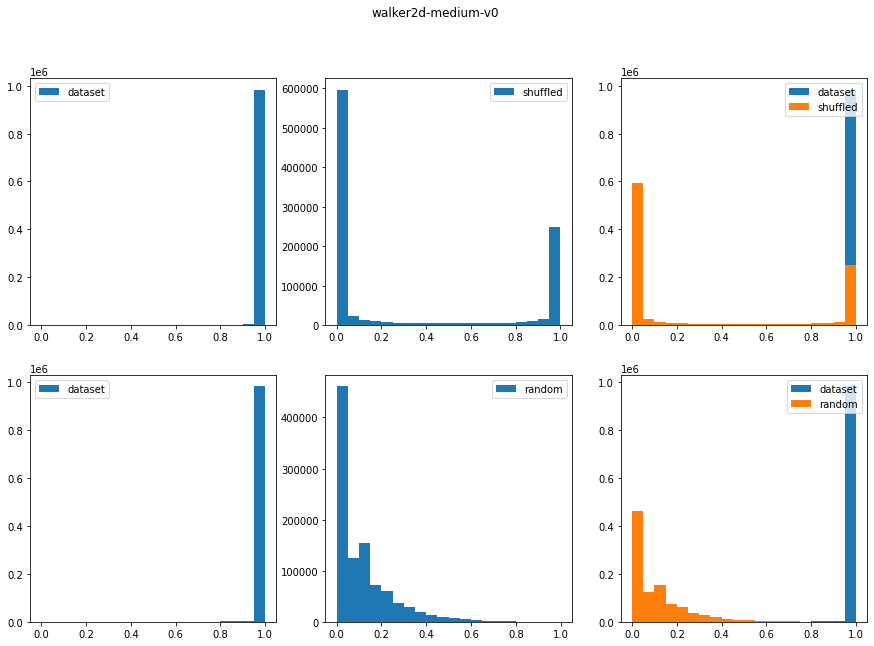

In [12]:
num_bins = 20
matplotlib.rcParams['figure.figsize'] = (15, 10)
fig=plt.figure()
plt.subplot(2, 3, 1)
plt.hist(bonus, bins = num_bins, label='dataset')
plt.legend()

plt.subplot(2, 3, 2)
plt.hist(bonus_shuffled, bins = num_bins, label='shuffled')
plt.legend()

plt.subplot(2, 3, 3)
plt.hist(bonus, bins = num_bins, label='dataset')
plt.hist(bonus_shuffled, bins = num_bins, label='shuffled')
plt.legend(loc='upper right')


plt.subplot(2, 3, 4)
plt.hist(bonus, bins = num_bins, label='dataset')
plt.legend()

plt.subplot(2, 3, 5)
plt.hist(bonus_random_mean, bins = num_bins, label='random')
plt.legend()

plt.subplot(2, 3, 6)
plt.hist(bonus, bins = num_bins, label='dataset')
plt.hist(bonus_random_mean, bins = num_bins, label='random')
plt.legend(loc='upper right')

plt.suptitle(env_name)

### bonus for noisy actions

In [33]:
N = 10

bonus_noisy_actions_sigma1 = get_bonus_noisy_actions(obs, actions, N, 0.1, network).detach().cpu().numpy()
bonus_noisy_actions_sigma2 = get_bonus_noisy_actions(obs, actions, N, 0.25, network).detach().cpu().numpy()
bonus_noisy_actions_sigma3 = get_bonus_noisy_actions(obs, actions, N, 0.75, network).detach().cpu().numpy()

bonus_noisy_actions_sigma1 = np.mean(bonus_noisy_actions_sigma1, axis=1)
bonus_noisy_actions_sigma2 = np.mean(bonus_noisy_actions_sigma2, axis=1)
bonus_noisy_actions_sigma3 = np.mean(bonus_noisy_actions_sigma3, axis=1)

noisy_actions size:torch.Size([10000000, 6])
size of bonus:torch.Size([10000000, 1])
noisy_actions size:torch.Size([10000000, 6])
size of bonus:torch.Size([10000000, 1])
noisy_actions size:torch.Size([10000000, 6])
size of bonus:torch.Size([10000000, 1])
